In [1]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append("../../")

import numpy
import pylab
from ctm.ctmLink import CTMLink
from ctm.variableLaneFDLink import VariableLaneFDLink
from ctm.triangularFundamentalDiagram import TriangularFundamentalDiagram
import ctm.capacityDropMerge
from continuousSingleCommodity.originNode import OriginNode
from continuousSingleCommodity.destinationNode import DestinationNode
from continuousSingleCommodity.mergeNode import MergeNode
from continuousSingleCommodity.oneToOneNode import OneToOneNode
from continuousSingleCommodity.divergeNode import DivergeNode

import simulationengine.simulationRunner as simulationRunner

In [2]:
import matplotlib

matplotlib.pyplot.rcParams.update({
  "text.usetex": False,
})
font = {'family': 'serif',
            'weight': 'normal' ,
            'size': 10}
matplotlib.rc('font',**font)
matplotlib.rc('text',usetex=False)
matplotlib.rc('axes',titlesize=10)
matplotlib.rc('axes',labelsize=10)
matplotlib.rc('figure',titlesize=10)
matplotlib.rc('legend',fontsize=10)

In [3]:
class LinkController:
    def __init__(self, link):
        self.link = link
        self.fd = TriangularFundamentalDiagram(vf=30.0, w=6.0, kj=0.1)
        self.fd2 = TriangularFundamentalDiagram(vf=30.0, w=6.0, kj=1.25*0.1)
    
    def start(self, time_step, total_time):
        pass

    def run_step(self, t):
        if t==40:
            self.link.set_switch(t, self.fd2, self.link.num_lanes)
        elif t==130:
            self.link.set_switch(t, self.fd, self.link.num_lanes)

In [3]:
priorities = [0.25, 0.75]

dem_1 = [1.4 for _ in range(12)]

for i in range(0,3):
    dem_1[i] = 1.35

dem_2 = [0.25 for _ in range(12)]
for p in range(8,12):
    dem_2[p] = 0.05
    dem_1[p] = 0.3

fd = TriangularFundamentalDiagram(vf=30.0, w=6.0, kj=0.1)
fd2 = TriangularFundamentalDiagram(vf=30.0, w=6.0, kj=1.25*0.1)
inbound_link_1 = CTMLink(link_id=1,length=300, kj=0.1, lm=30, fundamental_diagram=fd, num_lanes = 3)
inbound_link_2 = CTMLink(link_id=2, length=300, lm=30, fundamental_diagram=fd, num_lanes = 1)
outbound_link = VariableLaneFDLink(link_id=3, length=300, lm=30, fundamental_diagram=fd, num_lanes = 2, alpha_d=0.1)

origin_node_1 = OriginNode(1, inbound_link_1, dem_1)
origin_node_2 = OriginNode(2, inbound_link_2, dem_2)
#merge_node = MergeNode(3, [inbound_link_1, inbound_link_2], outbound_link, priorities)
merge_node = ctm.capacityDropMerge.CapacityDropMergeNode(3, inbound_link_1, inbound_link_2, outbound_link, theta_l=0.3, theta_r=0.1)

destination_node = DestinationNode(4, outbound_link)

links = [inbound_link_1, inbound_link_2, outbound_link]
nodes = [origin_node_1, origin_node_2, merge_node, destination_node]

controller = LinkController(outbound_link)


sim = simulationRunner.SimulationRunner(links = links, nodes = nodes, time_step = 1.0, total_time=150)
sim.general_purpose_objects = [controller]
sim.run()

f, axs = pylab.subplots(1, 2, figsize=(12, 4))

axs[0].set_title("Densities")
axs[1].set_title("Flows")

axs[0].plot(inbound_link_1.rho[inbound_link_1.num_cells-1,:], label="F-Upstream", color='blue')
axs[0].plot(inbound_link_2.rho[inbound_link_2.num_cells-1,:], label="R", color='orange')
axs[0].plot(outbound_link.rho[0,:], label="F-Downstream", color='green')

axs[1].plot(inbound_link_1.qs[inbound_link_1.num_cells-1,:], label="F-Upstream", color='blue')
axs[1].plot(inbound_link_2.qs[inbound_link_2.num_cells-1,:], label="R", color='orange')
axs[1].plot(outbound_link.qs[0,:], label="F-Downstream", color='green')
axs[1].plot(outbound_link.first_cell_demands, label="Demand", color='red', linestyle='--')

axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Density (veh/km)")
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Flow (veh/s)")

axs[0].legend()
axs[1].legend()

axs[0].axvline(40, color='red', linestyle='--', label='Switch Time')
axs[1].axvline(40, color='red', linestyle='--', label='Switch Time')

axs[0].axvline(130, color='purple', linestyle='--', label='Switch Time')
axs[1].axvline(130, color='purple', linestyle='--', label='Switch Time')

axs[0].axhline(outbound_link.fundamental_diagram.get_critical_density(), color='black', linestyle='--', label='Critical Density')
axs[1].axhline(outbound_link.fundamental_diagram.get_capacity()*outbound_link.num_lanes, color='black', linestyle='--', label='Capacity')

pylab.tight_layout()
pylab.show()

NameError: name 'LinkController' is not defined

In [5]:
upstream= [121.2304423470158, 131.3879445175207, 135.36620840292113, 147.45343204965957, 121.96855327856917, 136.16250478700508, 170.86073021737548, 138.27887569206703, 156.53101265303403, 184.09347202749888, 190.074076876655, 135.50197445882515, 225.05358652631566, 194.52991745353805, 158.90927262654236, 184.29717564341465, 204.76265926366142, 175.2389901908838, 184.27778049257103, 184.29717564341465, 195.6074980569125, 176.10322413497852, 155.90927262654236, 165.06443383329128, 160.88987747569874, 179.40390350511237, 180.52027441017404, 174.3457180525815, 174.3457180525815, 158.05479078992727, 153.9772101865528, 165.09358109161448, 171.1905568458326, 159.01600048824002, 139.64749262221136, 166.66677870893935, 155.4728272005032, 180.78314961400105, 169.6279884072521, 175.80254476484467, 142.2400853903798, 165.6085932564085, 152.39524659712873, 156.43403689881595, 153.33706114460438, 115.61944056338409, 149.3564562954415, 143.16250478700533, 135.22069023953617, 142.29827084291065]
ramp_counts= [6, 7, 4, 7, 7, 4, 8, 5, 5, 5, 8, 7, 10, 8, 10, 8, 8, 17, 9, 10, 11, 11, 14, 17, 16, 23, 15, 21, 25, 27, 23, 25, 17, 31, 19, 11, 20, 29, 12, 25, 20, 17, 24, 24, 9, 16, 10, 15, 18, 19]
up_density= [0.026694962949450337, 0.03106063384729535, 0.03538432767364516, 0.03625466363198721, 0.029289178244435964, 0.03448320802912783, 0.03688992515428742, 0.02916884372261033, 0.03720055931984489, 0.04808955144748759, 0.041806903848452356, 0.03325186558623812, 0.05728265020384717, 0.07016418084724625, 0.05731903183371273, 0.05391884150344934, 0.06893843634804683, 0.060400186078761936, 0.0670354482509307, 0.0742947760580191, 0.08494869374961996, 0.08299253769774935, 0.07720802368512794, 0.07168936529266301, 0.0654682833979379, 0.05337593354173561, 0.061564365707671466, 0.06029104452524612, 0.08530969940014739, 0.11055783326946088, 0.09371641634115532, 0.07492723860847415, 0.09245988815578061, 0.08398320692688671, 0.07372387921187415, 0.06328824629534537, 0.05471361689825556, 0.05576585766984456, 0.049919775450852376, 0.05166324633938163, 0.048598880921281985, 0.05405876924520108, 0.07044123068674286, 0.07768936677655178, 0.0466763075274318, 0.029429105569177598, 0.040486007650841524, 0.03805970272688723, 0.037721082178959205, 0.034469216088972875]

upstream = [el/120 for el in upstream]  #demand in steps of 2 minutes
ramp_counts = [el/120 for el in ramp_counts]
print(len(upstream), len(ramp_counts), len(up_density))

def get_base_fd():
    return TriangularFundamentalDiagram(vf=30.0, w=6.6, kj=0.105)

def get_network_with_demands():
    fd = get_base_fd()
    inbound_link_upstream = CTMLink(link_id=1, length=1200, lm=30, fundamental_diagram=fd, num_lanes=3)
    inbound_link_1 = VariableLaneFDLink(link_id=2, length=300, kj=0.1, lm=30, fundamental_diagram=fd, num_lanes=3, alpha_d=0.0, alpha_r=0.0)
    inbound_link_2 = CTMLink(link_id=10, length=300, lm=30, fundamental_diagram=fd, num_lanes=1)
    outbound_link = VariableLaneFDLink(link_id=3, length=300, lm=30, fundamental_diagram=fd, num_lanes=3, alpha_d=0.3, alpha_r=0.0)
    outbound_link_further = CTMLink(link_id=4, length=300, lm=30, fundamental_diagram=fd, num_lanes=3, alpha_d=0.0)
    off_ramp_link = CTMLink(link_id=11, length=300, lm=30, fundamental_diagram=fd, num_lanes=1)


    origin_node_1 = OriginNode(1, inbound_link_upstream, upstream)
    origin_node_2 = OriginNode(2, inbound_link_2, ramp_counts)
    one_one_node = OneToOneNode(7, inbound_link_upstream, inbound_link_1)
    merge_node = ctm.capacityDropMerge.CapacityDropMergeNode(3, inbound_link_1, inbound_link_2, outbound_link, theta_l=0.0, theta_r=0.25)
    node_diverge = DivergeNode(4, outbound_link, [outbound_link_further, off_ramp_link], turn_rates = [0.85, 0.15])

    destination_node = DestinationNode(5, outbound_link_further)
    destination_node_off_ramp = DestinationNode(6, off_ramp_link)

    links = [inbound_link_1, inbound_link_2, outbound_link, outbound_link_further, off_ramp_link, inbound_link_upstream]
    nodes = [origin_node_1, origin_node_2, merge_node, node_diverge, destination_node, destination_node_off_ramp, one_one_node]
    
    runner = simulationRunner.SimulationRunner(links=links, nodes=nodes, time_step=1.0, total_time=6000)
    return runner


50 50 50


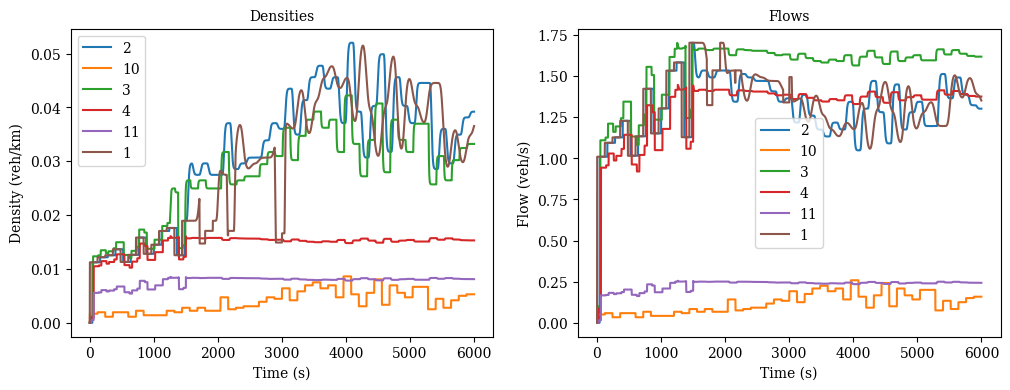

In [6]:
import pylab
run = get_network_with_demands()
run.run()

f, axs = pylab.subplots(1, 2, figsize=(12, 4))
for link in run.links:
    axs[0].plot(link.rho[0,:], label=link.link_id)
    axs[1].plot(link.qs[0,:], label=link.link_id)
axs[0].set_title("Densities")
axs[1].set_title("Flows")
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Density (veh/km)")
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Flow (veh/s)")
axs[0].legend()
axs[1].legend()



pylab.show()



In [7]:
class BaseController:
    def __init__(self, link, gamma, gamma_prime, control_step = 300):
        self.link = link
        self.fd = get_base_fd()
        self.gamma = gamma
        self.gamma_prime = gamma_prime
        self.control_step = control_step
        self.fd2 = TriangularFundamentalDiagram(vf = self.fd.vf*0.95, w=self.fd.w, kj=self.fd.kj*1.25)
        self.base_kc = self.fd.get_critical_density()
        print(self.fd.get_capacity(), self.fd2.get_capacity())
        self.control_actions = []
    
    def start(self, time_step, total_time):
        self.control_actions.append(False)

    def run_step(self, t):
        current = self.control_actions[-1]
        if t==0 or t % self.control_step != 0:
            return
        
        period_from = max(0, t-self.control_step)
        period_to = t
        rho = self.link.rho[0, period_from:period_to].flatten().mean()
        
        if current:
            if rho > self.gamma_prime*self.fd.get_critical_density():
                enable = True
            else:
                enable = False
        else:
            if rho > self.gamma*self.fd.get_critical_density():
                enable = True
            else:
                enable = False
        
        if enable != current:
            self.link.set_switch(t, self.fd2 if enable else self.fd, self.link.num_lanes)
        self.control_actions.append(enable)



class ScheduleTransitionController:
    def __init__(self, link, schedule, control_step = 60):
        self.link = link
        self.fd = get_base_fd()
        self.fd2 = TriangularFundamentalDiagram(vf = self.fd.vf*0.95, w=self.fd.w, kj=self.fd.kj*1.25)
        self.schedule = schedule
        self.control_step = control_step
        self.control_actions = []
    
    def start(self, time_step, total_time):
        self.control_actions.append(False)

    def run_step(self, t):
        current = self.control_actions[-1]
        if t==0 or t % self.control_step != 0:
            return
        
        if t in self.schedule and current != self.schedule[t]:
            enable = self.schedule[t]
            self.link.set_switch(t, self.fd2 if enable else self.fd, self.link.num_lanes)
            current = enable
        
        self.control_actions.append(current)

Case 0: Total travel time: 272.8641931140464 h, Queue TTs: 16.980722472702286 h
Case 0: Total travel distance: 18012.754553961022 km
[0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.058333333333333334, 0.058333333333333334, 0.058333333333333334, 0.058333333333333334, 0.058333333333333334, 0.058333333333333334, 0.058333333333

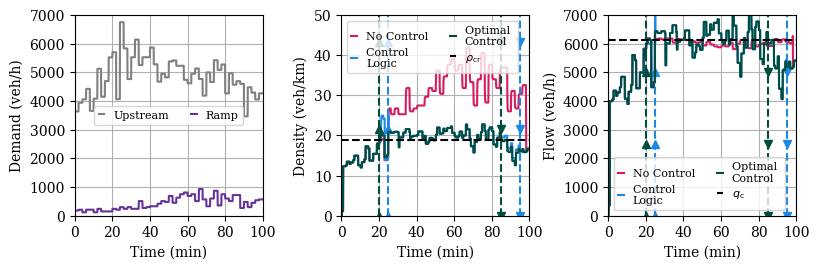

In [17]:

#controller = BaseController(runner.links[2], gamma=0.9, gamma_prime=0.8, control_step=60)

labels = ["No Control", "Control \nLogic", "Optimal \nControl"]
line_style = ['solid', 'solid', 'solid']	
linewidths = [None, None, None]
colors = ['#D81B60', '#1E88E5', '#004D40']

fontsize=8

f, axs = pylab.subplots(1, 3, figsize=(8, 2.5))
for case in range(3):
    runner = get_network_with_demands()
    # binary_schedule = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1 ,1, 1 ,1 ,1, 1 ,1, 1, 1, 1 ,1 ,1 ,1 ,1, 1, 1 ,1 ,1, 1 ,1 ,1 ,1 ,1 ,1, 1,
    # 1, 1, 0 ,0 ,0, 0, 0, 0, 0, 0, 0 ,0 ,0]
    binary_schedule=[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]
    
    if case == 0:
        for link in runner.links:
            fd = TriangularFundamentalDiagram(vf=1.00*link.fundamental_diagram.vf, 
                                              w=1.035*link.fundamental_diagram.w, 
                                              kj=link.fundamental_diagram.kj)
            link.fundamental_diagram = fd


    controller = None
    if case == 1:
        controller = BaseController(runner.links[2], gamma=0.92, gamma_prime=0.9, control_step=300)
    elif case == 2:
        

        time_step = 6000/len(binary_schedule)
        schedule = {}
        for i in range(1,len(binary_schedule)):
            if binary_schedule[i] != binary_schedule[i-1]:
                schedule[int(i*time_step)] = binary_schedule[i]

        controller = ScheduleTransitionController(runner.links[2], schedule=schedule, control_step=300)
    
    if controller is not None:    
        runner.general_purpose_objects = [controller]
    runner.run()
    
    total_travel_time = 0
    total_demand = 0
    for node in runner.nodes:
        if isinstance(node, OriginNode):
            total_travel_time += sum(node.entry_queue) * node.time_step
            total_demand += sum(node.demands_at_steps) * node.time_step
    
    queue_tts = total_travel_time
    total_travel_distance = 0
    for link in runner.links:
        total_travel_time += sum(sum(link.rho[:,:])) * link.time_step*link.num_lanes*link.lm
        total_travel_distance += sum(link.qs[0,:]) * link.time_step*link.length
    
    print(f"Case {case}: Total travel time: {total_travel_time/3600} h, Queue TTs: {queue_tts/3600} h")
    print(f"Case {case}: Total travel distance: {total_travel_distance/1000} km")
    
    if case == 0:
        print(runner.nodes[1].demands_at_steps)
        times = [i/60 for i in range(len(runner.nodes[1].demands_at_steps))]
        axs[0].plot(times, [el*3600 for el in runner.nodes[0].demands_at_steps], label="Upstream", color='gray')
        axs[0].plot(times, [el*3600 for el in runner.nodes[1].demands_at_steps], label="Ramp", color='rebeccapurple')
        #axs[0].set_title("Demands")
        axs[0].set_xlabel("Time (min)")
        axs[0].set_ylabel("Demand (veh/h)")
        axs[0].legend(fontsize=fontsize, loc=0, ncols=2, handlelength=0.5)
        axs[0].set_ylim((0, None))
        axs[0].grid(True)
        

    #axs[0].plot(runner.links[0].rho[runner.links[1].rho.shape[0]-1,:], label=labels[case], linestyle=line_style[case])
    times = [i/60 for i in range(runner.links[2].rho.shape[1]-1)]
    axs[1].plot(times, runner.links[2].rho[0,1:]*1000, label=labels[case], linestyle=line_style[case], color=colors[case])
    axs[2].plot(times, runner.links[2].qs[0,:]*3600, linestyle=line_style[case], label=labels[case], linewidth=linewidths[case], color=colors[case])
    
    # if case == 0:
    #     axs[1].plot(runner.links[2].first_cell_demands, label="Eff_cd", color='red', linestyle='--')

    if controller is None:
        continue

    for i in range(1,len(controller.control_actions)):
        transition_positive = controller.control_actions[i] and not controller.control_actions[i-1]
        transition_negative = not controller.control_actions[i] and controller.control_actions[i-1]
        
        if not transition_positive and not transition_negative:
            continue
        
        num_markers = 4
        max_value_density = 65
        max_value_flow = 7500
        series_density = [(max_value_density/(num_markers-1))*u for u in range(num_markers)]
        series_flow = [(max_value_flow/(num_markers-1))*u for u in range(num_markers)]
        times_d = [controller.control_step*i/60 for u in range(num_markers)]
        
        if transition_positive:
            marker = "^"
        else:
            marker = "v"
            
        axs[1].plot(times_d, series_density , color=colors[case], linestyle='dashed',  marker=marker, linewidth=linewidths[case])
        axs[2].plot(times_d, series_flow, color=colors[case], linestyle='dashed', marker=marker, linewidth=linewidths[case])


axs[1].axhline(runner.links[2].fundamental_diagram.get_critical_density()*1000, color='black', linestyle='--', label='$\\rho_\\mathrm{cr}$')
axs[2].axhline(runner.links[2].fundamental_diagram.get_capacity()*runner.links[2].num_lanes*3600, color='black', linestyle='--', label="$q_\\mathrm{c}$")

#axs[1].set_title("Densities")
#axs[2].set_title("Flows")
axs[1].set_xlabel("Time (min)")
axs[2].set_ylabel("Density (veh/km/lane)")
axs[2].set_xlabel("Time (min)")
axs[2].set_ylabel("Flow (veh/h)")
axs[1].legend(fontsize=fontsize, ncols=2, handlelength=0.5)
axs[2].legend(fontsize=fontsize, ncols=2, handlelength=0.5)
axs[1].set_ylim((0, None))
axs[2].set_ylim((0, None))
axs[1].set_ylabel("Density (veh/km)")

for i in range(3):
    axs[i].grid(True)
    axs[i].set_xlim((0, 100))
    axs[i].set_xticks([0, 20, 40, 60, 80, 100])

axs[0].set_ylim((0, 7000))
axs[1].set_ylim((0, 50))
axs[2].set_ylim((0, 7000))

pylab.tight_layout(w_pad=0.05, h_pad=0.02, pad=0.02)
pylab.savefig("C:\\users\\fdesouza\\Downloads\\results.pdf", dpi=500)
pylab.show()